# Graph Analysis file
Used for the analysis of graphs

In [49]:
import igraph
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import csv
import sys
import time

from graph_functions import polynomial

from scipy.odr import ODR, Model, Data, RealData

In [50]:
%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
%aimport graph_functions

In [52]:
%matplotlib inline
# %matplotlib qt5

# plt.style.use('default')
plt.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Times New Roman"],
        "font.size":11,
    })

save_plots=False

## Read in csv file

In [53]:
csv.field_size_limit(sys.maxsize)

data_dict = {}
filename = 'deezer'
with open(f'real_data/{filename}.csv', newline='') as f:
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        data_dict[row[0].lower().replace(" ", "_")] = [float(v) for v in row[1][1:-1].split(', ')]

In [54]:
d_log = np.array(data_dict['full_degree'])
c_inv = np.array(data_dict['full_closeness'])

d_np = np.exp(d_log)
c_np = 1/c_inv

x = np.array(data_dict['avg_degree'])
y = np.array(data_dict['avg_closeness'])
sdx = np.array(data_dict['degree_sd'])
sdy = np.array(data_dict['closeness_sd'])

In [6]:
N = 5_000
m = 4
p = 3 # Expected number of edges per node

# ## Can make many "citation ones"
g = igraph.Graph.Barabasi(N,m)
# g = igraph.Graph.Erdos_Renyi(N, p=2*p/N)
# g = igraph.Graph.Tree(N,2)
# g = igraph.Graph.GRG(N,0.1)
# g = igraph.Graph.Establishment(N,m,[1],[[1]])
# g = igraph.Graph.Growing_Random(N, m, citation=False)
# g = igraph.Graph.Recent_Degree(N, m,10)

g = max(g.decompose(), key=igraph.Graph.vcount)

# g = g.spanning_tree()

d_np = np.array(g.degree())
c_np = np.array(g.closeness())
d_log = np.log(d_np)
c_inv = 1 / c_np
x,y,sdx,sdy = graph_functions.closeness_and_degree_to_x_y_bins(c_np, d_np)

## Polynomial Model Fitting - ODR

In [55]:
# Model
poly_model = Model(polynomial)

# Data
bin_data = RealData(x,y,sdx,sdy)
raw_data = RealData(d_log, c_inv)

# Binned odr
bin_odr = ODR(bin_data, poly_model, [1.9,-0.2])
bin_odr.set_job(fit_type=0)
bin_odr_out = bin_odr.run()

# Raw odr
raw_odr = ODR(raw_data, poly_model, [2,-1])
raw_odr.set_job(fit_type=2)
raw_odr_out = raw_odr.run()

In [56]:
raw_odr_list = []
for i in range(0,8):
    raw_odr = ODR(raw_data, poly_model, [0] * (i + 1))
    raw_odr.set_job(fit_type=2)
    raw_odr_out = raw_odr.run()
    raw_odr_list.append(raw_odr_out)

In [57]:
# g.ecount()/g.vcount()

## $\bar z$ calculation
$$\bar{z}=\frac{\left\langle k^{2}\right\rangle}{\langle k\rangle}-1$$

In [58]:
z_predicted = np.average(np.exp(d_log)**2) / np.average(np.exp(d_log)) - 1

z_bin = np.exp(-1/bin_odr_out.beta[1])
z_bin_err = np.sqrt((((1/bin_odr_out.beta[1]) * z_bin)*bin_odr_out.sd_beta[1])**2)

z_raw = np.exp(-1/raw_odr_list[1].beta[1])
z_raw_err = np.sqrt((((1/raw_odr_out.beta[1]) * z_raw)*raw_odr_out.sd_beta[1])**2)

In [59]:
z_raw

4.732264985925895

Date: 22-11-2020
Measuring the branching factor directly by looking at the number of connected nodes in a neighborhood of order $\ell$. 
$$n_l=n_0 \bar z^\ell$$
$$n_0\equiv1$$
$$\Rightarrow z=n_\ell^{1/\ell}$$

This is a further approximation of the already approximated relationship
$$n_{\ell}=\bar{z}^{\ell-1} n_{1}, \quad \ell \geq 1$$

In [80]:
n_len_list = []
z_vals_list = []
rnd_node_list = []

for k in range(1):
    n_len = []
    random_node = np.random.randint(0,g.vcount())
    rnd_node_list.append(random_node)
    for i in range(20):
        n_len.append(len(g.neighborhood(vertices=random_node, order=i)))
    n_len_list.append(n_len)

for ns in n_len_list:
    z_vals = []
    for i in range(1,len(ns)):
        nl = ns[i]
        z = nl ** (1/i)
        z_vals.append(ns[i] ** (1/i))
        # print(nl,z)
    z_vals_list.append(z_vals)

In [83]:
g.vcount()

5000

In [62]:
rnd_nodes = np.random.randint(0,g.vcount(),size=(1,1))[0]

In [63]:
map_res = list(map(lambda node: [len(g.neighborhood(vertices=node, order=i)) ** 1/i for i in range(1,20)], rnd_node_list))

In [64]:
map_res

[[5.0,
  22.5,
  191.0,
  930.0,
  999.8,
  833.3333333333334,
  714.2857142857143,
  625.0,
  555.5555555555555,
  500.0,
  454.54545454545456,
  416.6666666666667,
  384.61538461538464,
  357.14285714285717,
  333.3333333333333,
  312.5,
  294.11764705882354,
  277.77777777777777,
  263.1578947368421]]

## Chi-Squared

In [65]:
# Own calculation of chi^2
# chi_bin = sum(((y - polynomial(bin_odr_out.beta, x))/sdy)**2)
# chi_bin_red = chi_bin / (len(x) - 0)
# chi_raw = sum(((c_inv - polynomial(raw_odr_out.beta, d_log)))**2)
# chi_raw_red = chi_raw  / len(d_log)
# chi_raw_bin_odr = sum(((c_inv - polynomial(bin_odr_out.beta, d_log)))**2)
# chi_raw_bin_odr_red = chi_raw_bin_odr / len(d_log)

chi_raw = graph_functions.chi_squared(d_log, c_inv, polynomial, raw_odr_out.beta) 
chi_bin = sum(((y - polynomial(bin_odr_out.beta, x))/sdy)**2)
chi_raw_bin_odr = graph_functions.chi_squared(d_log, c_inv, polynomial, bin_odr_out.beta) 

chi_func = graph_functions.chi_squared(d_log, c_inv, polynomial, raw_odr_out.beta)

raw_chi_list = []
raw_lik_list = []
for o in raw_odr_list:
    chi, like = graph_functions.chi_likelihood_combined(polynomial, o.beta, d_log, c_inv)
    raw_chi_list.append(chi)
    raw_lik_list.append(like)

In [66]:
print(stats.chisquare(c_inv, polynomial(raw_odr_out.beta, d_log), ddof=3))
# print(stats.chisquare(c_inv, polynomial(raw_odr_out.beta, d_log), ddof=78401))

Power_divergenceResult(statistic=3170.9731451435337, pvalue=1.0)


## Residuals

In [67]:
raw_res = list(map(lambda point: (point[1] - polynomial(raw_odr_out.beta, point[0])), zip(d_log, c_inv)))
raw_res_mean, raw_res_std = stats.norm.fit(raw_res)

raw_res_bin_odr = list(map(lambda point: (point[1] - polynomial(bin_odr_out.beta, point[0])), zip(d_log, c_inv)))
raw_res_bin_odr_mean, raw_res_bin_odr_std = stats.norm.fit(raw_res_bin_odr)

bin_res = list(map(lambda point: (point[1] - polynomial(bin_odr_out.beta, point[0])), zip(x, y)))
bin_res_mean, bin_res_std = stats.norm.fit(bin_res)

## Likelihood and BIC
BIC is not necessary here since we're not comparing models with different parameters, but definitely needs to be in the paper. 

In [68]:
'''Could be same issue that happened with the chi.
try doing the variance for each degree value.'''
chi_bin_combined, bin_odr_log_L = graph_functions.chi_likelihood_combined(polynomial, bin_odr_out.beta, x, y, sdy=sdy)
raw_chi_c, raw_odr_log_L = graph_functions.chi_likelihood_combined(polynomial, raw_odr_out.beta, d_log, c_inv)
chihihi, raw_bin_odr_log_L = graph_functions.chi_likelihood_combined(polynomial, bin_odr_out.beta, d_log, c_inv)
# bin_odr_log_L = graph_functions.log_likelihood_gauss_regression(polynomial, bin_odr_out.beta, bin_res_std, x, y)
# raw_odr_log_L = graph_functions.log_likelihood_gauss_regression(polynomial, raw_odr_out.beta, bin_res_std, d_log, c_inv)
# raw_bin_odr_log_L = graph_functions.log_likelihood_gauss_regression(polynomial, bin_odr_out.beta, raw_res_bin_odr_std, d_log, c_inv)

In [69]:
bin_odr_log_L

-28.511043823602407

In [70]:
# BIC chi is weird
# BIC var is weirder
bin_lin_bic = graph_functions.bic_value_chi(chi_bin, len(x), 2)
raw_lin_bic = graph_functions.bic_value_chi(chi_raw, len(d_log), 2)

raw_bic_list = []
for odr, L in zip(raw_odr_list, raw_lik_list):
    
    # print(chi, len(d_log), len(odr.beta))
    # raw_bic_list.append(graph_functions.bic_value_chi(chi, len(d_log), len(odr.beta)))
    # res_var = np.var(c_inv - polynomial(odr.beta, d_log))
    # raw_bic_list.append(graph_functions.bic_value_var(res_var, len(d_log), len(odr.beta)))
    # print(res_var)
    # f, beta, gaussian_std, x, y
    # like = graph_functions.log_likelihood_gauss_regression(polynomial, odr.beta, x,y)
    raw_bic_list.append(graph_functions.bic_value_log(L, len(d_log), len(odr.beta)))

In [71]:
raw_bic_list

[89044.77407362386,
 64279.77037317467,
 64070.048062346854,
 64087.86321312481,
 64067.425000267045,
 64067.27654351704,
 64084.615518613246,
 64092.390141777054]

# Presentation

## Data graphs

In [72]:
# plt.scatter(d_np, c_np, s=1, label='Raw, unprocessed data')

# plt.xlabel('Degree')
# plt.ylabel('Closeness')
# plt.legend()
# plt.show()

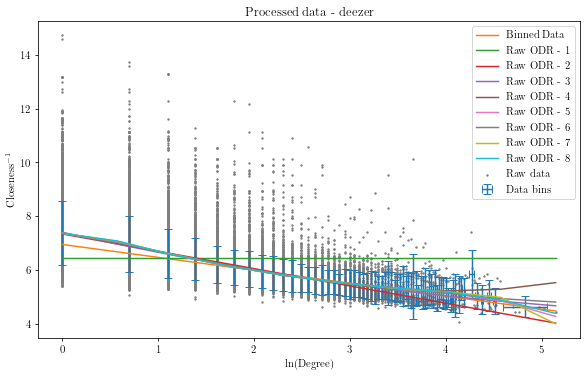

In [73]:
x_lin = np.linspace(min(d_log), max(d_log), 10)

plt.figure(figsize=(10,6), dpi=70)

plt.scatter(d_log, c_inv, s=2, label='Raw data', c='tab:grey')
plt.errorbar(x,y,xerr=sdx,yerr=sdy, linestyle='None',capsize=4, label='Data bins')

plt.plot(x_lin, polynomial(bin_odr_out.beta,x_lin), label='Binned Data')
# plt.plot(x_lin, polynomial(raw_odr_out.beta,x_lin), label='Raw Data')

for odr in raw_odr_list:
    plt.plot(x_lin, polynomial(odr.beta, x_lin), label=f'Raw ODR - {len(odr.beta)}')
# filename = 'test'
plt.title(f"Processed data - {filename}")
plt.xlabel('ln(Degree)')
plt.ylabel('Closeness$^{-1}$')
plt.legend()
# plt.show()

if save_plots:
    plt.savefig(f'real_plots/{filename}_data_{int(time.time())}.png')

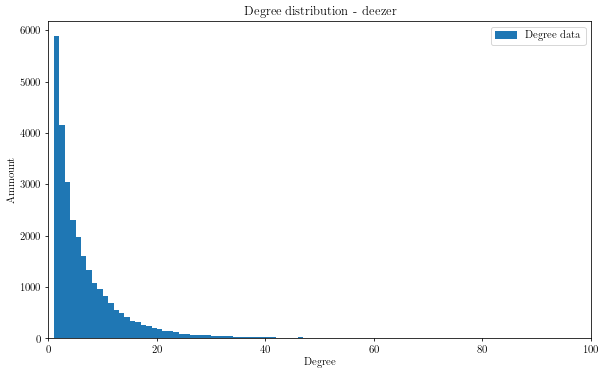

In [74]:
plt.figure(figsize=(10,6), dpi=70)

res_hist = plt.hist(d_np, bins=round(max(d_np))-round(min(d_np)), label="Degree data")
# plt.yscale('log')
plt.title(f"Degree distribution - {filename}")
plt.xlabel('Degree')
plt.ylabel('Ammount')
# plt.xscale('log')
# plt.yscale('log')
plt.xlim((0,100))
# plt.ylim((0,100))
plt.legend()
# plt.show()
if save_plots:
    plt.savefig(f'real_plots/{filename}_dist_{int(time.time())}.png') 

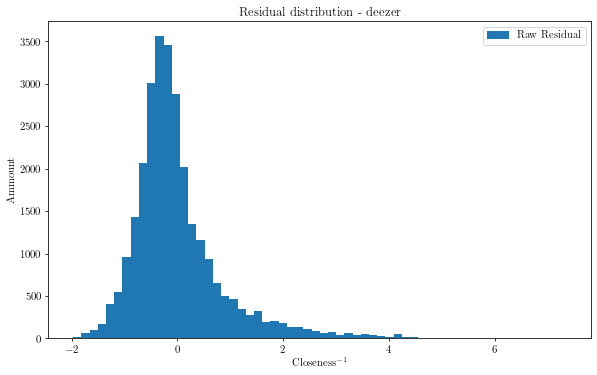

In [75]:
plt.figure(figsize=(10,6), dpi=70)

res_hist = plt.hist(raw_res, bins=60, label="Raw Residual")
# res_hist = plt.hist(bin_res, bins=30, label="Bin Residual")
# plt.yscale('log')
plt.title(f"Residual distribution - {filename}")
plt.xlabel('Closeness$^{-1}$')
plt.ylabel('Ammount')
# plt.xlim((0,100))
# plt.ylim((0,100))
plt.legend()
# plt.show()
if save_plots:
    plt.savefig(f'real_plots/{filename}_residuals_{int(time.time())}.png')

## Metrics

In [76]:
betas = [[raw_odr_out.beta, raw_odr_out.sd_beta], [bin_odr_out.beta, bin_odr_out.sd_beta]]
zs = [[z_raw, z_raw_err],[z_bin, z_bin_err],[z_predicted]]
chis = [[chi_raw], [chi_bin], [chi_raw_bin_odr]]
chis_r = [[chi_raw/len(d_log)], [chi_bin/len(x)], [chi_raw_bin_odr/len(d_log)]]
log_Ls = [[raw_odr_log_L], [bin_odr_log_L], [raw_bin_odr_log_L]]
bics = [[raw_lin_bic], [bin_lin_bic]]
bics_lin = [[raw_bic_list]]

graph_functions.print_metrics(betas, zs, chis, chis_r, log_Ls, bics, raw_bic_list)
print('\n\n\nStill quite suspicous of the log likelihood...')
print('Chi-squared funciton on raw data', chi_func/len(d_log))

                        Raw                     Bin                     Raw/Bin                 
Gradient                +0.405 ± 0.345          -0.48 ± 0.0299         
z                       +4.732 ± 4.029          +8.028 ± 0.4999         Predicted: 15.19                   
z fraction              +0.3116 ± 0.2653        +0.5286 ± 0.03292       
Chi-squared             2.83e+04                8.46                    2.97e+04                
Chi-squared (R)         1                       0.124                   1.05                    
BIC                     2.83e+04                16.9                    
BIC 0                   89045                   
BIC 1                   64280                   
BIC 2                   64070                   
BIC 3                   64088                   
BIC 4                   64067                   
BIC 5                   64067                   
BIC 6                   64085                   
BIC 7                   64092           

In [77]:
for i, v in enumerate(zip(raw_bic_list, raw_chi_list)):
    print(f'{i} | {v[0]:.5g} | {v[1]:.5g}')

0 | 89045 | 54849
1 | 64280 | 28584
2 | 64070 | 28363
3 | 64088 | 28355
4 | 64067 | 28331
5 | 64067 | 28321
6 | 64085 | 28325
7 | 64092 | 28322


In [78]:
raw_odr_list[1].beta

array([ 7.33605106, -0.64333342])

In [79]:
bin_odr_out.beta

array([ 6.94683404, -0.48010524])

# Results
## Preliminary observations
N ~ 1-10k in igraph, m ~ 3:
- Works: "Barabasi" (good), "Erdos" (very good), "Establishment" (okay), "Generate Random" (okay)
- Dosn't work: "GRG" (not good), "Tree" (Terrible)

Graph specific comments:
- **Barabasi** As established earlier the Barabasi plot works decently well
- **Erdos-Reni** Taking the largest connected component works even better than the Barabasiit seems. Could be because it has a smaller and more even distribution of degree values meaning we get nicer statistics. 
    - Predicts the z value very well (z frac ~ 0.9)
    - $\chi ^2$ value is way too small 
    - ln(L) is either very close to 0 or infinite...
    - For dense Erdos graph we get a very straight relationship but the z value is really wrong. Probbaly because adding edges has a deminishing effect on the z value prediction. An added edge has a larger probability to increase closness if there aren't many edges. Eventually though, the new edge doesn't increase the closenss that much but the degree is still increased the same. 
- **Tree** The igraph tree seems to give every vertex the exact same number of edges, except for the leaves. This means there are only two degree values in the graph, making it pretty useless and unrealistic. 
- **GRG** the GRG seems to have a poission distribution of edges which is interesting. So far i have not gotten it to work nicely. It gives values which are all over the place. 
    - Very hard to control the number of edges and connected subgraphs. 
- **Establishment** Has an inverse exponential degree distribution. Works similarly to Barabasi but has not preference over attaching new nodes. Sees a clear bend in the data graph meaning the fits aren't amazing. Somehow they still get very good chi fits though. 
    - Setting *citation* to True doesn't seem to be doing much.
- **Generate random** Similar degree distribution to Establishment but a lot larger spread of the values. Generates very straight data but still doesn't predict z value better than z frac = ~0.45. Chi square ~ 0.1-0.4

General comments:
- The more random the graph creation process, the more poission like the degree distribution. Thus, Erdos-Reni and GRG both have very poission like distributions. 
- Need the BIC fit to see if the chi fit, though good, is correct. Like if there is a better fit.
    - Ex: High m Barabasi. We get a clearly curvy pattern (snake!) but the absolute fit is still good because the closness values are not scattered as much. 
    - Comparing a small spread of c values which create a clear pattern will have a better reduced chi squared compared to the low m even though the low m has a much straighter fit. 
- There is probably a dense limit relationship too because the really high m Barabasi has a really smooth, nice, curve of the data, not linear though. 
- **NEW $\chi ^2$ FUNCTION:** works better i think, it gives a reduced value of almost exactly 1 for the graphs which are supposed to work. Gives an insanely high value for p=100 in the erdos graph, indicating the fit isn't good, which it isn't supposed to be. The previsous way of calculating though is really small indicating it's the wrong way of doing it.
- Decreaseing the errors in y (sdy) increases the chi-squared value for the bin fits. This means that the errors are "Too big". However the errors are from the data and not somethig we can change...

## Rigorous testing comments
### Real Networks
#### Summary
- cit  
    - Gets better z prediction if end values are heavier weighted. 